In [3]:
from dotenv import load_dotenv
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


load_dotenv()



llm = init_chat_model(
    "openai:o4-mini",
)

class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ...,
        description="Classify if the message requires an emotional or logical message type"
    )

class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str | None



def classify_message(state: State):
    last_message = state['messages'][-1].content
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as either:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """
        },
        {"role": "user", "content": last_message}
    ])

    return {"message_type": result.message_type}


def router(state: State):
    message_type = state.get("message_type", "logical")
    print(f"message type: {message_type}")
    if message_type == "emotional":
        return {"next": "therapist"}
    
    return {"next": "logical"}

def therapist_agent(state: State):
    last_message = state["messages"][-1].content

    messages = [
        {"role": "system",
         "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
         },
        {
            "role": "user",
            "content": last_message
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


def logical_agent(state: State):
    last_message = state["messages"][-1].content

    messages = [
        {"role": "system",
         "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
         },
        {
            "role": "user",
            "content": last_message
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


graph_builder = StateGraph(State)

graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)

graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("logical", logical_agent)


graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {
        "therapist": "therapist", "logical": "logical"
    }
)

graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)

graph = graph_builder.compile()


def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
        user_input = input("Message: ")
        if user_input == "exit":
            print("Bye")
            break

        state["messages"] = state.get("messages", []) + [
            {"role": "user", "content": user_input}
        ]
        print("State before invoking")
        print(state)

        state = graph.invoke(state)

        print("State before invoking")
        print(state)
        
        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            print(f"Assistant: {last_message.content}")


# if __name__ == "__main__":
#     run_chatbot()

In [16]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.chains import RetrievalQA
from langchain.chat_models import init_chat_model
from openai import OpenAI
from langchain.embeddings.base import Embeddings
from openai import OpenAI
from dotenv import load_dotenv
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

load_dotenv()

llm = init_chat_model(
    "openai:o4-mini",
    temperature=0
)

prompt = hub.pull("rlm/rag-prompt")  # You can switch to another like langchain-ai/retrieval-qa-chat
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

class CustomOpenAIEmbedding(Embeddings):
    def __init__(self, model: str = "text-embedding-3-small", dimensions: int = 1536):
        self.client = OpenAI()
        self.embedding_model_id = model
        self.embedding_size = dimensions

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        response = self.client.embeddings.create(
            model=self.embedding_model_id,
            input=texts,
            dimensions=self.embedding_size
        )
        return [e.embedding for e in response.data]

    def embed_query(self, text: str) -> list[float]:
        response = self.client.embeddings.create(
            model=self.embedding_model_id,
            input=[text],
            dimensions=self.embedding_size
        )
        return response.data[0].embedding
    

class State(TypedDict):
    messages: Annotated[list, add_messages]
    claim_data: dict
    decision: str

graph_builder = StateGraph(State)

# Step 1: Create vector index from PDF
def build_vector_index(pdf_path="data/company_X_quotation.pdf"):
    loader = PyMuPDFLoader(pdf_path)
    docs = loader.load()

    # Chunk the PDF
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = splitter.split_documents(docs)

    # Build vector store
    embedding = CustomOpenAIEmbedding(model="text-embedding-3-small", dimensions=256)

    vector_store = FAISS.from_documents(chunks, embedding)
    return vector_store

retriever = build_vector_index().as_retriever(search_kwargs={"k": 4})

qa_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm
    | StrOutputParser()
)

# Node: Validate claim using retrieval-based reasoning
def validate_claim(state: State):
    claim = state["claim_data"]
    print(f"claim data: {claim}")

    query = f"""
    Given the following claim data:
    {claim}

    Based on the company quotation document. 
    Please Ignore the claim date and quotation date.

    
    should this claim be approved or rejected?
    Reply with only one word: accept or reject. Justify your decision briefly.
    """

    response = qa_chain.invoke(query)
    print(f"response: {response}")

    if "accept" in response.lower():
        decision = "accept"
    else:
        decision = "reject"

    return {"decision": decision}

def final_decision(state: State):
    return {"messages": [{"role": "system", "content": f"Claim is {state['decision']}"}]}

graph_builder.add_node("validate_claim", validate_claim)
graph_builder.add_node("final_decision", final_decision)
graph_builder.add_edge(START, "validate_claim")
graph_builder.add_edge("validate_claim", "final_decision")
graph_builder.add_edge("final_decision", END)

graph = graph_builder.compile()

claim = {
    "claim_id": "1234",
    "company_id": "Al Sagr Cooperative Insurance",
    "amount": 4000,
    "member_id": "A456",
    "member_name": "Sameeh",
    "class": "VIP",
    "diagnosis": "dental consultations",
    "date": "2024-05-01"
}

# result = graph.invoke({"claim_data": claim, "messages": []})
# print(result['messages'][-1].content)


d:\Github Repos\Learn-LangChain\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


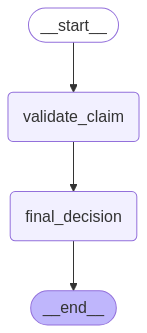

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [ ]:
# start -> extract_claim -> validate_claim with quotation -> get response

In [1]:
from langchain_docling import DoclingLoader

d:\Github Repos\Learn-LangChain\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import json
company_name = "company_X"

with open(f"data/processed/{company_name}.json", "r") as f:
    data = json.load(f)

In [23]:
class_ = "VIP"

In [26]:
data['English']['AdditionalBenefits']['Values'][class_] + data['English']['HighLevelBenefit']['Values'][class_]

[{'Benefit': 'Out-Patient Coverage', 'Sagr': 'No info'},
 {'Benefit': 'Emergency Services',
  'Sagr': '100% subject to the: Reasonable\nCustomary charges as per KSA price list of\nthe same network for the same class'},
 {'Benefit': 'Pre-Existing and Chronic Conditions', 'Sagr': 'Covered'},
 {'Benefit': 'Vaccinations', 'Sagr': 'Covered'},
 {'Benefit': 'Ambulance Services', 'Sagr': 'Covered'},
 {'Benefit': 'Hearing Aids', 'Sagr': 'SR. 6,000'},
 {'Benefit': 'Congenital and Newborn Coverage', 'Sagr': 'Covered'},
 {'Benefit': 'Psychiatric Illnesses', 'Sagr': 'SR. 50,000'},
 {'Benefit': 'Obesity Surgery', 'Sagr': 'SR. 15,000'},
 {'Benefit': 'Repatriation', 'Sagr': 'SR. 10,000'},
 {'Benefit': 'Consultation Fees',
  'Sagr': 'General Practitioner/specialist (First Registrar Doctor): SR. 100-150, Specialist (Second Registrar Doctor)/ Consultant: SR. 200-300, Specializations with scarcity: SR. 400'},
 {'Benefit': 'Dialysis', 'Sagr': 'SR. 180,000'},
 {'Benefit': 'Alzheimer Disease', 'Sagr': 'SR. 1

[{'Benefit': 'Annual Limit', 'Sagr': 'Million Saudi Riyals'},
 {'Benefit': 'Network', 'Sagr': 'SAGR01'},
 {'Benefit': 'Accommodation', 'Sagr': 'Standard Suit'},
 {'Benefit': 'Co-insurance/Deductible', 'Sagr': '20%'},
 {'Benefit': 'Medication Co-pay',
  'Sagr': 'Generic medicine: 20% Maximum SR. 30, Innovative treatment: 50% from the innovative\ntreatment'},
 {'Benefit': 'Dental Limit',
  'Sagr': 'Essential and Preventive Dentistry: SR. 4200, Treatment of Root Canals and Emergencies: SR. 800'},
 {'Benefit': 'Optical Limit', 'Sagr': '1500 SAR'},
 {'Benefit': 'Maternity ( normal deliveries, antenatal and postnatal cares )',
  'Sagr': '15,000 SAR'},
 {'Benefit': 'Caesarean deliveries', 'Sagr': 'No info'}]

In [16]:
company_benefits = json.dumps(data['English']['AdditionalBenefits']) + "\n" + json.dumps(data['English']['HighLevelBenefit'])
len(company_benefits)

7556

In [5]:
FILE_PATH = "data/company_Y_quotation.pdf"

In [67]:
# loader = PyMuPDFLoader(pdf_path)
loader = DoclingLoader(file_path=FILE_PATH)
docs = loader.load()

d:\Github Repos\Learn-LangChain\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [57]:
print(docs[11].page_content)

: المؤهلون للتأمين
الحد الاقصى ا داخل خارج لمستشفيات الحد شبكة . الموحدة الادنى. Maximum limit for the other health care providers out of the minimum unified network., Class VIP.SAGR01.Benefits and limits of the insurance under the Policy = SR. 0. Maximum limit for the other health care providers out of the minimum unified network., Class VIP.SAGR01. = 0 ريال. Maximum limit for the other health care providers out of the minimum unified network., التأمين درجة.الطبية الشبكة.الوثيقة بموجب التأمينية التغطية وحدود منافع = الحد الاقصى الحد شبكة خارج الخدمة مقدمي لباقي . الموحدة الادنى. Co-insurance of medicines prescribed by outpatient clinics, Class VIP.SAGR01.Benefits and limits of the insurance under the Policy = Co-insurance of medicines prescribed by outpatient clinics. Co-insurance of medicines prescribed by outpatient clinics, Class VIP.SAGR01. = ل التحمل نسبة الخارجية العيادات من الموصوفة الأدوية نفقات :. Co-insurance of medicines prescribed by outpatient clinics, التأمين درجة.الطبية

In [6]:
from docling.document_converter import DocumentConverter

converter = DocumentConverter()
result = converter.convert(FILE_PATH)
pdf_text = result.document.export_to_text()

Parameter `strict_text` has been deprecated and will be ignored.


In [9]:
print(pdf_text)

## Jordan Insurance Company

| 3       | الصحي التامين لبرنامج الاضافيه المنافع             |
|---------|----------------------------------------------------|
| 4       | الصحي التامين لبرنامج العامه الإستثناءات           |
| 5       | الصحي التامين لبرنامج الانتظار فترات               |
| 6       | هامه تعريفات و عامه تحديدات                        |
| 7       | العقد جدول توضيحات                                 |
| 8 - 9   | المشتركين دليل - مدنت خدمات                        |
| 10 - 11 | اضافيه معلومات                                     |
| 14 - 12 | رقم الصحي التامين عرض - 1 - CLASSIC                |
| 18 - 15 | رقم الصحي التامين عرض - 2 - QUALITY                |
| 19      | المعتمده الطبيه الشبكه خارج الطبيه المطالبات تعويض |

-  تغطية أمراض السرطان
-  تغطية أمرا ض القلب وجراحته
-  ( تغطية تكلفة الشبكة الطبية (STENT
-  تغطية امراض العمود الفقري وجراحته
-  تغطية علاج مرض انفلونزا الخنازير ( H1N1)
-  تغطية الطفل المولود من اليوم الاول
-  تسقط فترات الانتظار عن المواليد الج

In [61]:
pdf_text = result.document.export_to_text()

Parameter `strict_text` has been deprecated and will be ignored.


In [7]:
print(result.document.export_to_markdown())

<!-- image -->

## Jordan Insurance Company

<!-- image -->

| 3       | الصحي التامين لبرنامج الاضافيه المنافع             |
|---------|----------------------------------------------------|
| 4       | الصحي التامين لبرنامج العامه الإستثناءات           |
| 5       | الصحي التامين لبرنامج الانتظار فترات               |
| 6       | هامه تعريفات و عامه تحديدات                        |
| 7       | العقد جدول توضيحات                                 |
| 8 - 9   | المشتركين دليل - مدنت خدمات                        |
| 10 - 11 | اضافيه معلومات                                     |
| 14 - 12 | رقم الصحي التامين عرض - 1 - CLASSIC                |
| 18 - 15 | رقم الصحي التامين عرض - 2 - QUALITY                |
| 19      | المعتمده الطبيه الشبكه خارج الطبيه المطالبات تعويض |

<!-- image -->

-  تغطية أمراض السرطان
-  تغطية أمرا ض القلب وجراحته
-  ( تغطية تكلفة الشبكة الطبية (STENT
-  تغطية امراض العمود الفقري وجراحته
-  تغطية علاج مرض انفلونزا الخنازير ( H1N1)
-  تغطية الطفل المولود من الي

In [63]:
# Chunk the PDF
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=400)
chunks = splitter.split_documents(docs)

In [64]:
chunks = splitter.split_text(pdf_text)

In [65]:
len(chunks), len(docs)

(276, 191)

In [ ]:
chu

In [40]:
print(chunks[5].page_content)

درجة التأمين 
Class VIP 
Class of Insurance 
 الشبكة الطبية 
SAGR01 
Network Name 
 منافع وحدود التغطية التأمينية بموجب الوثيقة 
Benefits and limits of the insurance under the Policy 
 حد المنفعة األقصى لكل شخص عن سنة
 الوثيقة ويشمل ذلك الحدود الدنيا الواردة في
هذه الوثيقة:
 
مالحظة: 
  يتم دعم المنشآت الصغيرة و
المتوسطة 
 ( والتي تضم اقل من250
  
 موظف
 وايرادات اقل من200
  
  مليون لاير عند اصدار
)الوثيقة عما 
 يتجاوز500
 
 الف لاير من
برنامج صندوق الضمان.
 
مليون لاير سعودي 
Million Saudi Riyals 
The maximum benefit limit for each person 
for the year of the Policy, including the 
minimum limits mentioned herein:  
Note: 
Small 
and 
medium 
enterprises 
(Number of employees less than 250 and 
annual revenue less than SR. 200 million at 
policy issuance) are supported through 
Insurance Daman program for expenses 
exceeding SR.500 thousand. 
:نفقات المعالجة بالعيادات الخارجية 
Out-patient treatment costs:   
يلتزم المستفيد ( المؤمن له) بدفع نسبة التحمل ( أي المشاركة في الدفع) عند زي

In [26]:
docs

[Document(metadata={'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2024-06-03T14:33:00+03:00', 'source': 'data/company_X_quotation.pdf', 'file_path': 'data/company_X_quotation.pdf', 'total_pages': 29, 'format': 'PDF 1.7', 'title': '', 'author': 'Abdullah S. Abdulwahed', 'subject': '', 'keywords': '', 'moddate': '2024-06-03T14:33:00+03:00', 'trapped': '', 'modDate': "D:20240603143300+03'00'", 'creationDate': "D:20240603143300+03'00'", 'page': 0}, page_content='عرض األسعار واتفاقية التأمين\nالطبي \nQuotation Offer & Medical Insurance \nAgreement\n \n \n \nبرنامج التأمين الطبي للشركات \n \nCorporate Medical Insurance Program'),
 Document(metadata={'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2024-06-03T14:33:00+03:00', 'source': 'data/company_X_quotation.pdf', 'file_path': 'data/company_X_quotation.pdf', 'total_pages': 29, 'format': 'PDF 1.7', 'title': '', 'author': 'Abdullah S. Abdulwahed', 'subject': '',